用DDQN解决棍子摇摆问题

DQN伪代码：

<div align='center'>
<img src="../images/c5/DQN.png" alt="Q学习" width="400">
</div>

DDQN目标是： $Q(s_{i},a_{i}) \longleftrightarrow r_{i} + \hat{Q}(s_{i+1},\arg \max_{a}Q(s_{i+1},a))$

首先要初始化俩个相同参数的网络 $Q$ 和 $\hat Q$ ,这个网络的输入是状态，输出对应每个动作的 $Q$ 值。

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class cfg():
    """配置类，存储所有超参数"""
    max_episodes = 1000          # 最大训练episode数
    max_steps = 200            # 每个episode的最大步数
    batch_size = 64            # 批量大小
    learning_rate = 0.001      # 学习率
    gamma = 0.99               # 折扣因子
    epsilon_start = 1.0        # 初始探索率
    epsilon_end = 0.01         # 最终探索率
    epsilon_decay = 0.995      # 探索率衰减
    target_update = 10         # 目标网络更新频率
    memory_size = 10000        # 经验回放缓冲区大小
    hidden_dim = 128           # 隐藏层维度
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
class Net(nn.Module):
    """深度Q网络 - 使用全连接层"""
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    """经验回放缓冲区"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """存储一个transition"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """随机采样batch_size个transition"""
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state), np.array(action), np.array(reward), 
                np.array(next_state), np.array(done))
    
    def __len__(self):
        return len(self.buffer)

In [31]:
class DQNAgent():    
    def __init__(self, state_dim, action_dim, cfg):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = cfg.device
        
        # 网络初始化
        self.policy_net = Net(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        self.target_net = Net(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        
        # 复制参数到目标网络
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # 优化器
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.learning_rate)
        
        # 经验回放
        self.memory = ReplayBuffer(cfg.memory_size)
        
        # 探索参数
        self.epsilon = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        
        # 其他参数
        self.batch_size = cfg.batch_size
        self.gamma = cfg.gamma
        
    def select_action(self, state,test=False):
        """选择动作 - epsilon贪心策略"""
        if random.random() < self.epsilon and not test:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.argmax().item()
    
    def update(self):
        """更新网络"""
        if len(self.memory) < self.batch_size:
            return
        
        # 从经验回放中采样
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # 转换为tensor
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
        # 当前Q值
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # 计算目标Q值 (DDQN)
        with torch.no_grad():
            # 使用policy网络选择动作
            next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
            # 使用target网络评估Q值
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q_values = rewards.unsqueeze(1) + (self.gamma * next_q_values * ~dones.unsqueeze(1))
        
        # 计算损失
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        # 优化
        self.optimizer.zero_grad()
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # 衰减epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

In [32]:
import gymnasium as gym
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pygame.pkgdata")

# 创建环境
env = gym.make('CartPole-v1') 
n_states = env.observation_space.shape[0]  # 状态维度
n_actions = env.action_space.n  # 动作维度

print("状态维度:", n_states)
print("动作维度:", n_actions)
print("状态空间:", env.observation_space)
print("动作空间:", env.action_space)

# 测试环境
obs, info = env.reset()
print("\n初始观测:", obs)
print("观测形状:", obs.shape)

action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)
print("执行动作", action, "后:")
print("新观测:", obs)
print("奖励:", reward)
print("是否结束:", terminated or truncated)

# 初始化智能体
cfg = cfg()
agent = DQNAgent(n_states, n_actions, cfg)
print(f"\n智能体初始化完成!")
print(f"使用设备: {cfg.device}")
print(f"初始探索率: {agent.epsilon}")
print(f"经验回放缓冲区容量: {len(agent.memory)}")

状态维度: 4
动作维度: 2
状态空间: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
动作空间: Discrete(2)

初始观测: [ 0.01680424 -0.03111739 -0.01558775  0.04998405]
观测形状: (4,)
执行动作 1 后:
新观测: [ 0.01618189  0.16422457 -0.01458807 -0.2475759 ]
奖励: 1.0
是否结束: False

智能体初始化完成!
使用设备: cpu
初始探索率: 1.0
经验回放缓冲区容量: 0


开始训练DDQN智能体...
训练参数: episodes=1000, batch_size=64, lr=0.001


训练进度:   5%|▌         | 50/1000 [00:03<02:48,  5.63it/s]

Episode: 50, 平均奖励: 44.64, 步数: 114, 探索率: 0.010


训练进度:  10%|█         | 100/1000 [00:19<04:18,  3.48it/s]

Episode: 100, 平均奖励: 177.94, 步数: 164, 探索率: 0.010


训练进度:  15%|█▍        | 149/1000 [00:35<03:41,  3.84it/s]

Episode: 150, 平均奖励: 177.26, 步数: 31, 探索率: 0.010


训练进度:  20%|██        | 200/1000 [00:46<03:16,  4.07it/s]

Episode: 200, 平均奖励: 136.22, 步数: 158, 探索率: 0.010


训练进度:  25%|██▌       | 250/1000 [01:00<03:52,  3.23it/s]

Episode: 250, 平均奖励: 166.40, 步数: 200, 探索率: 0.010


训练进度:  30%|███       | 300/1000 [01:14<03:09,  3.69it/s]

Episode: 300, 平均奖励: 155.24, 步数: 172, 探索率: 0.010


训练进度:  35%|███▌      | 350/1000 [01:29<03:46,  2.87it/s]

Episode: 350, 平均奖励: 182.16, 步数: 200, 探索率: 0.010


训练进度:  40%|████      | 400/1000 [01:45<03:27,  2.89it/s]

Episode: 400, 平均奖励: 193.04, 步数: 200, 探索率: 0.010


训练进度:  45%|████▌     | 450/1000 [02:02<02:30,  3.66it/s]

Episode: 450, 平均奖励: 192.74, 步数: 200, 探索率: 0.010


训练进度:  50%|████▉     | 499/1000 [02:17<02:09,  3.86it/s]

Episode: 500, 平均奖励: 182.82, 步数: 54, 探索率: 0.010


训练进度:  55%|█████▌    | 551/1000 [02:31<01:43,  4.34it/s]

Episode: 550, 平均奖励: 148.88, 步数: 135, 探索率: 0.010


训练进度:  60%|██████    | 600/1000 [02:43<02:05,  3.19it/s]

Episode: 600, 平均奖励: 146.14, 步数: 197, 探索率: 0.010


训练进度:  65%|██████▌   | 650/1000 [02:58<01:52,  3.10it/s]

Episode: 650, 平均奖励: 165.06, 步数: 200, 探索率: 0.010


训练进度:  70%|███████   | 700/1000 [03:13<01:41,  2.95it/s]

Episode: 700, 平均奖励: 175.44, 步数: 200, 探索率: 0.010


训练进度:  75%|███████▌  | 750/1000 [03:29<00:55,  4.50it/s]

Episode: 750, 平均奖励: 182.90, 步数: 107, 探索率: 0.010


训练进度:  80%|████████  | 802/1000 [03:43<00:28,  6.89it/s]

Episode: 800, 平均奖励: 144.04, 步数: 60, 探索率: 0.010


训练进度:  85%|████████▌ | 850/1000 [03:58<00:55,  2.69it/s]

Episode: 850, 平均奖励: 166.32, 步数: 200, 探索率: 0.010


训练进度:  90%|█████████ | 900/1000 [04:17<00:37,  2.68it/s]

Episode: 900, 平均奖励: 200.00, 步数: 200, 探索率: 0.010


训练进度:  95%|█████████▌| 950/1000 [04:36<00:14,  3.36it/s]

Episode: 950, 平均奖励: 194.36, 步数: 103, 探索率: 0.010


训练进度: 100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


Episode: 1000, 平均奖励: 188.24, 步数: 200, 探索率: 0.010
训练完成!


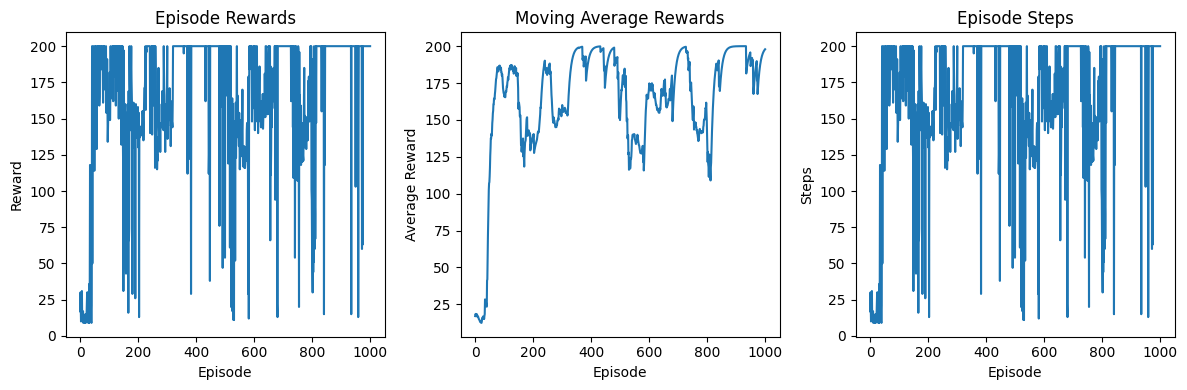

In [33]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# 训练DDQN智能体
rewards = [] # 记录总的rewards
moving_average_rewards = [] # 记录总的经滑动平均处理后的rewards
ep_steps = []

print("开始训练DDQN智能体...")
print(f"训练参数: episodes={cfg.max_episodes}, batch_size={cfg.batch_size}, lr={cfg.learning_rate}")

for i_episode in tqdm(range(1, cfg.max_episodes+1), desc="训练进度"):
    obs, info = env.reset() # reset环境状态
    ep_reward = 0
    
    for i_step in range(1, cfg.max_steps+1):
        action = agent.select_action(obs) # 根据当前环境state选择action
        next_obs, reward, terminated, truncated, info = env.step(action) # 更新环境参数
        done = terminated or truncated
        
        ep_reward += reward
        agent.memory.push(obs, action, reward, next_obs, done) # 将transition存入memory
        obs = next_obs # 跳转到下一个状态
        
        agent.update() # 每步更新网络
        
        if done:
            break
    
    # 更新target network，复制policy_net中的所有weights and biases
    if i_episode % cfg.target_update == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())
    
    # 记录训练信息
    ep_steps.append(i_step)
    rewards.append(ep_reward)
    
    # 计算滑动窗口的reward
    if i_episode == 1:
        moving_average_rewards.append(ep_reward)
    else:
        moving_average_rewards.append(0.9*moving_average_rewards[-1] + 0.1*ep_reward)
    
    # 每50个episode打印一次信息
    if i_episode % 50 == 0:
        avg_reward = np.mean(rewards[-50:])
        print(f'Episode: {i_episode}, 平均奖励: {avg_reward:.2f}, 步数: {i_step}, 探索率: {agent.epsilon:.3f}')

print("训练完成!")

# 绘制训练结果
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 3, 2)
plt.plot(moving_average_rewards)
plt.title('Moving Average Rewards')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

plt.subplot(1, 3, 3)
plt.plot(ep_steps)
plt.title('Episode Steps')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

开始测试DDQN智能体...
注意：测试时不会进行探索，使用纯贪心策略


测试回合:  25%|██▌       | 1/4 [00:08<00:25,  8.55s/it]

测试回合 1: 奖励=200.0, 步数=200


测试回合:  50%|█████     | 2/4 [00:17<00:17,  8.52s/it]

测试回合 2: 奖励=200.0, 步数=200


测试回合:  75%|███████▌  | 3/4 [00:25<00:08,  8.52s/it]

测试回合 3: 奖励=200.0, 步数=200


测试回合: 100%|██████████| 4/4 [00:34<00:00,  8.52s/it]

测试回合 4: 奖励=200.0, 步数=200

测试完成!
平均奖励: 200.00
平均步数: 200.00
最高奖励: 200.0
最低奖励: 200.0


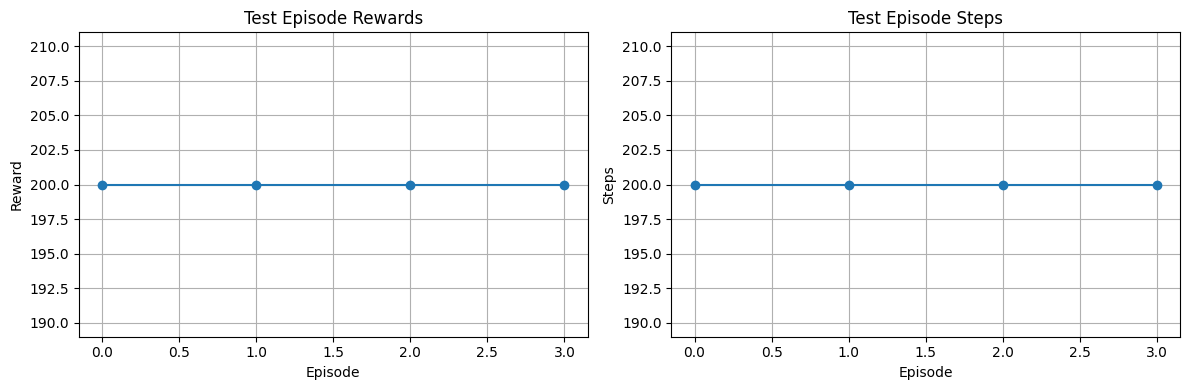

In [35]:
# 测试训练好的DDQN智能体
import time

# 重新创建带渲染的环境
test_env = gym.make('CartPole-v1', render_mode='human') 
test_rewards = [] # 记录测试奖励
test_steps = []

print("开始测试DDQN智能体...")
print("注意：测试时不会进行探索，使用纯贪心策略")

for i_episode in tqdm(range(1, 5), desc="测试回合"):  # 减少测试回合数
    obs, info = test_env.reset() # reset环境状态
    ep_reward = 0
    
    for i_step in range(1, cfg.max_steps+1):
        # 测试时使用贪心策略（test=True）
        action = agent.select_action(obs,test=True) 
        next_obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        
        # 正确的渲染方式
        test_env.render()
        time.sleep(0.02)  # 稍微减慢速度以便观看
        
        ep_reward += reward
        obs = next_obs # 跳转到下一个状态
        
        if done:
            break
    
    # 记录测试信息
    test_steps.append(i_step)
    test_rewards.append(ep_reward)
    print(f"测试回合 {i_episode}: 奖励={ep_reward:.1f}, 步数={i_step}")

test_env.close()

# 显示测试结果统计
print(f"\n测试完成!")
print(f"平均奖励: {np.mean(test_rewards):.2f}")
print(f"平均步数: {np.mean(test_steps):.2f}")
print(f"最高奖励: {max(test_rewards)}")
print(f"最低奖励: {min(test_rewards)}")

# 绘制测试结果
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(test_rewards, 'o-')
plt.title('Test Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_steps, 'o-')
plt.title('Test Episode Steps')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)

plt.tight_layout()
plt.show()